In [2]:
# Notebook for the skewed experiments

from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

import scienceplots
plt.style.use(['science', 'no-latex', 'light'])

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models/"

In [3]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

NotADirectoryError: [Errno 20] Not a directory: '../models/.DS_Store'

# Plot pre-computed metrics

linear_regression_mamba pretrained_mamba


100%|██████████| 15/15 [00:00<00:00, 206955.79it/s]


linear_regression_no_pos pretrained_no_pos


100%|██████████| 15/15 [00:00<00:00, 240131.91it/s]


<Figure size 2000x1200 with 0 Axes>

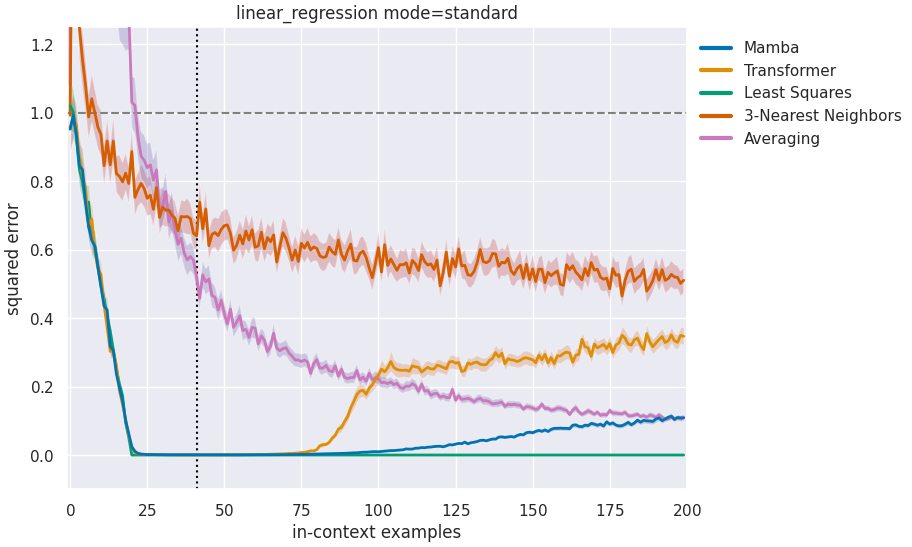

sparse_regression_mamba pretrained_mamba


100%|██████████| 1/1 [00:00<00:00, 21290.88it/s]


sparse_regression_no_pos pretrained_no_pos


100%|██████████| 1/1 [00:00<00:00, 23301.69it/s]


<Figure size 2000x1200 with 0 Axes>

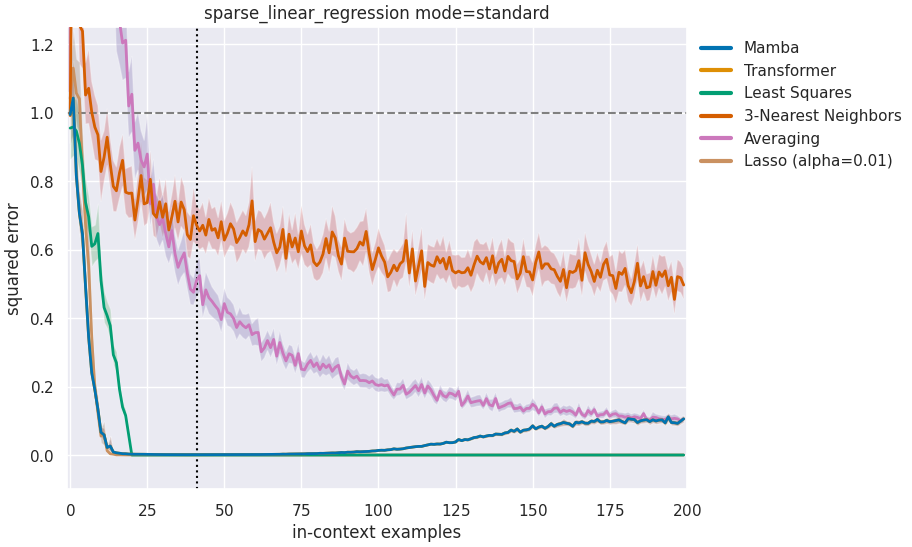

decision_tree_mamba pretrained_mamba


100%|██████████| 1/1 [00:00<00:00, 21959.71it/s]


decision_tree_no_pos pretrained_no_pos


100%|██████████| 1/1 [00:00<00:00, 23172.95it/s]


<Figure size 2000x1200 with 0 Axes>

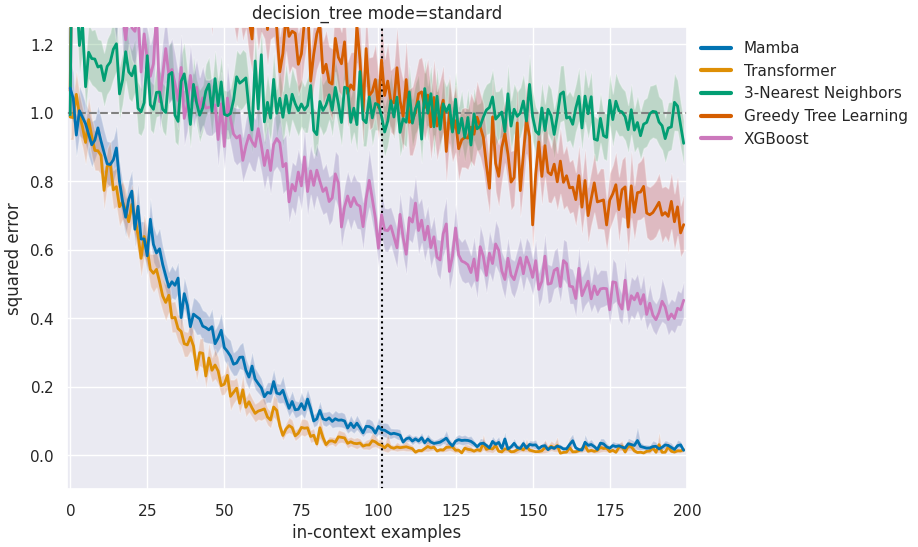

relu_2nn_regression_mamba pretrained_mamba


100%|██████████| 2/2 [00:00<00:00, 42366.71it/s]


relu_2nn_regression_no_pos pretrained_no_pos


100%|██████████| 2/2 [00:00<00:00, 44150.57it/s]


<Figure size 2000x1200 with 0 Axes>

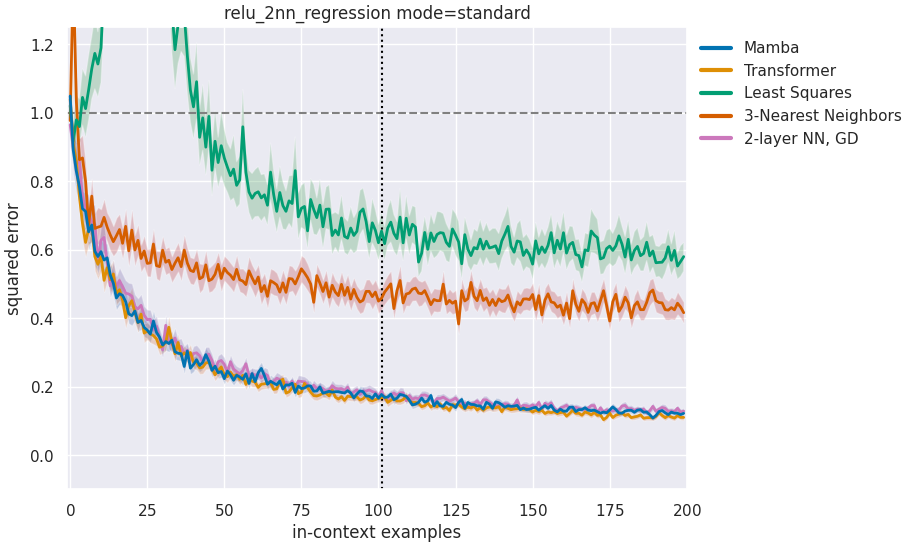

In [20]:
 # these are normally precomputed at the end of training
for task in (
    "linear_regression",
    "sparse_linear_regression",
    "decision_tree",
    "relu_2nn_regression",
):

    run_ids = (
        "pretrained_mamba",
        # "pretrained", 
        # "pretrained_new",
        "pretrained_no_pos",
        )  

    for run_id in run_ids:
        run_path = os.path.join(run_dir, task, run_id)
        recompute_metrics = False

        if recompute_metrics:
            get_run_metrics(run_path) 


    xlim = 200
    # xlim = 100
    # xlim = None

    def valid_row(r):
        return r.task == task and r.run_id in run_ids

    def rename_mamba(x, r):
        return x if 'mamba' not in x else 'Mamba'

    metrics = collect_results(run_dir, df, valid_row=valid_row, rename_model=rename_mamba,
                              no_recompute=True, xlim=xlim)
    _, conf = get_model_from_run(run_path, only_conf=True)
    n_dims = conf.model.n_dims
    n_train_points = conf.training.curriculum.points.end



    models = relevant_model_names[task].copy()
    # models.remove('Mamba')
    # models.remove('Transformer')

    plt.figure(figsize=(20, 12))     
    basic_plot(metrics["standard"], models=models, title=f"{task} mode=standard", n_train_points=n_train_points,
               size_mult=2.)
    plt.savefig(f"../imgs/no_pos/{task}.pdf")
    plt.show()

In [12]:
metrics.keys()

dict_keys(['linear_regression', 'standard'])

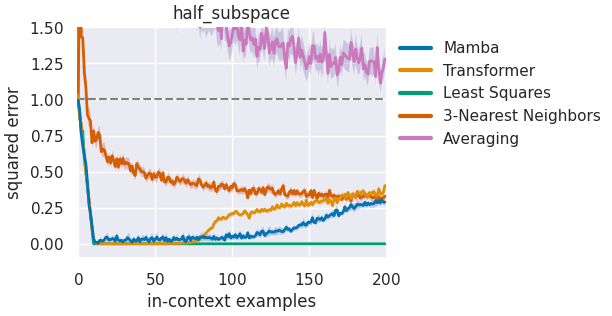

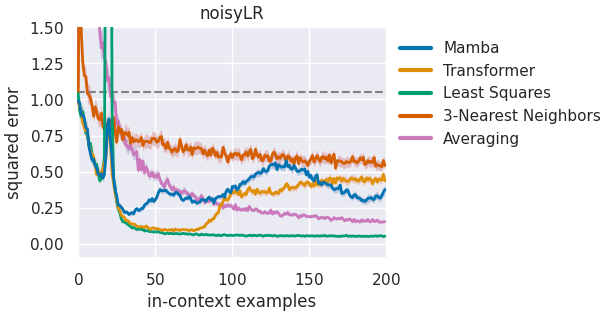

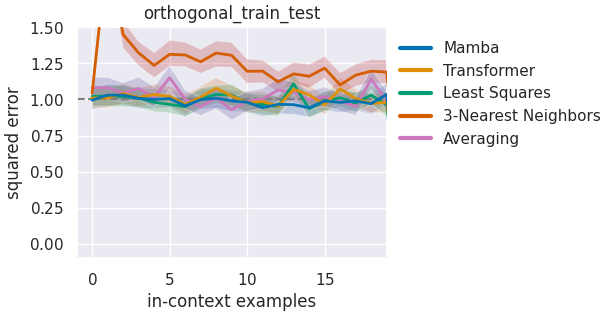

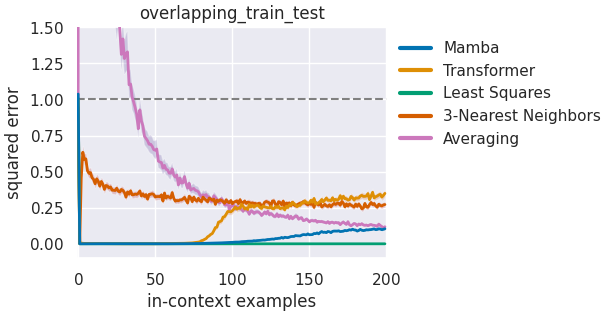

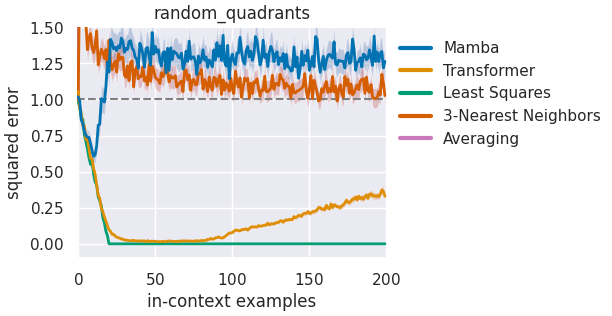

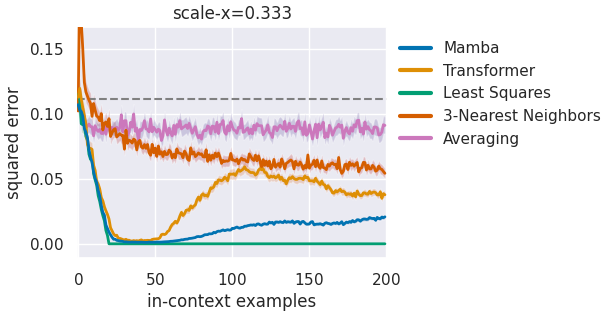

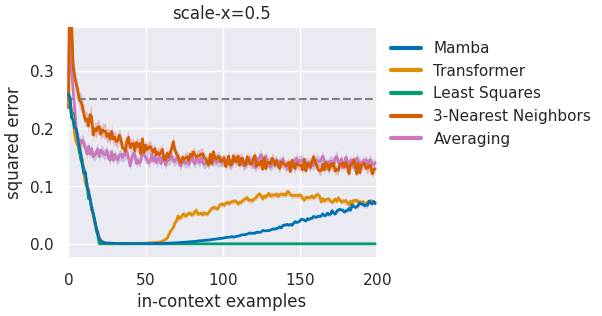

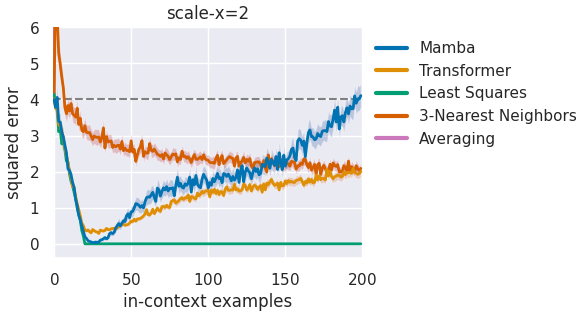

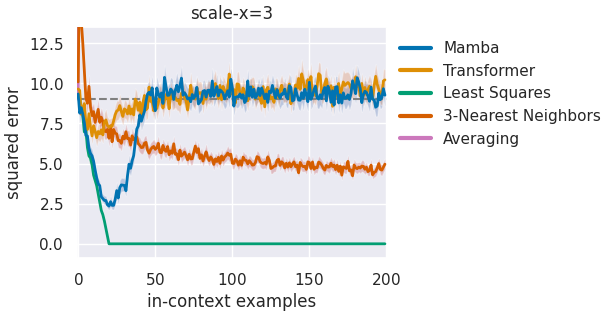

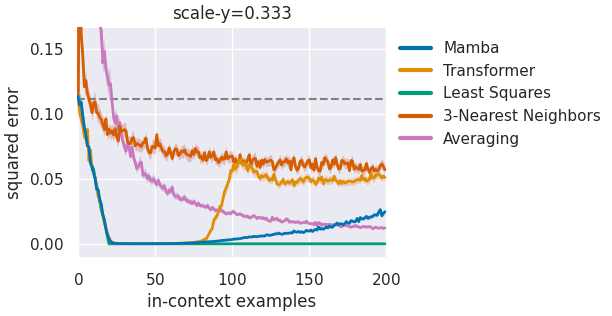

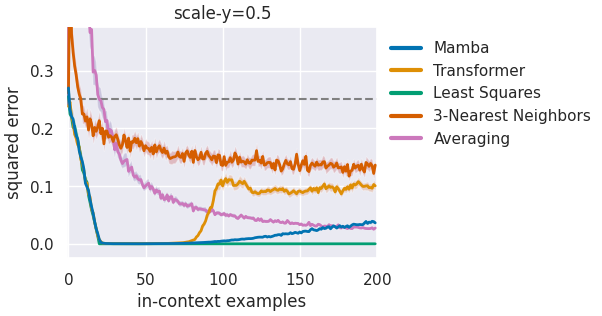

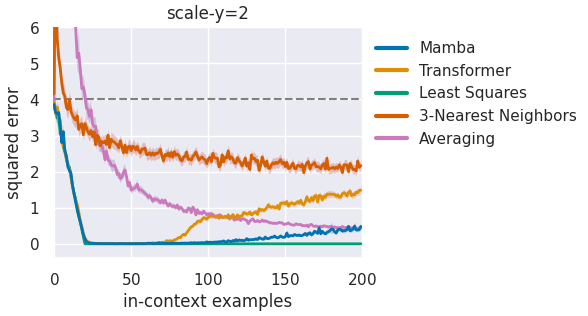

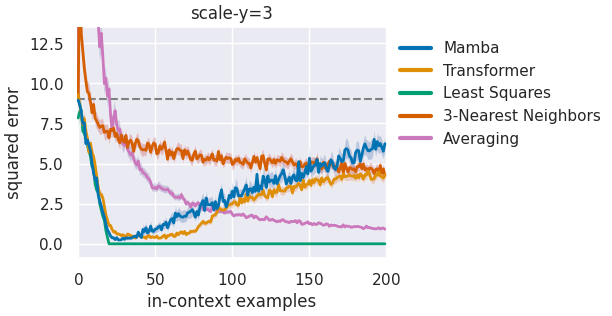

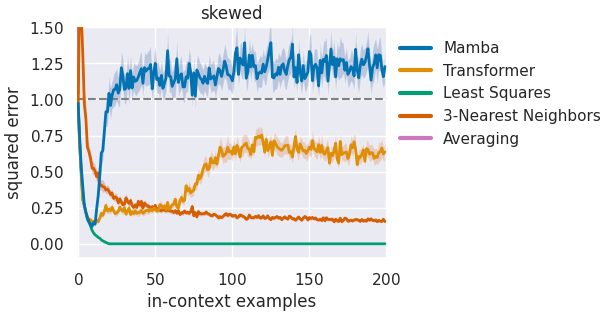

In [10]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)
    # plt.savefig(f"../imgs/out_of_dist/{name}.pdf")
    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [21]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [22]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [23]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [24]:
with torch.no_grad():
    pred = model(xs, ys)

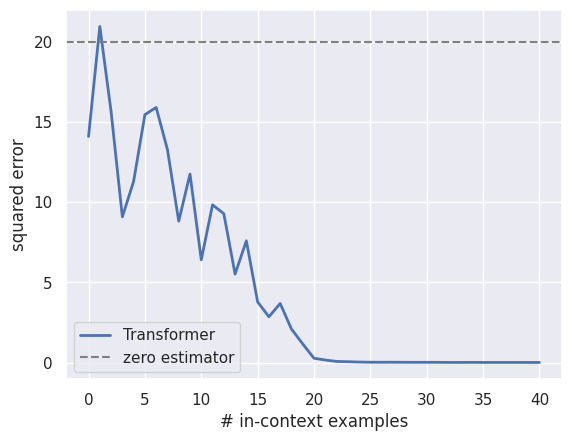

In [25]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [26]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

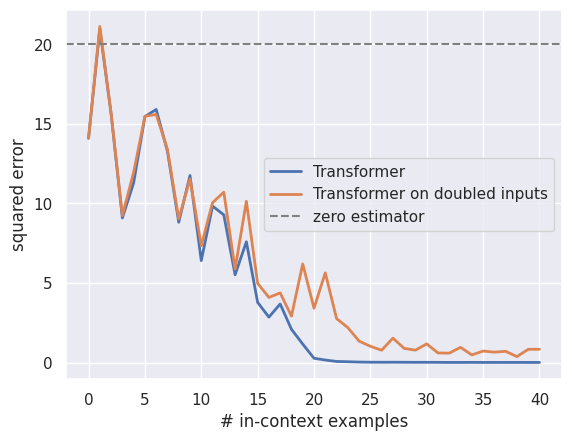

In [27]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.